In [1]:
import pandas as pd

In [2]:
import matplotlib
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
import scipy

In [5]:
from scipy import stats

In [6]:
import os

In [7]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import preprocessing

In [8]:
from joblib import Parallel, delayed
from sklearn.utils import resample
import datetime

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score
from sklearn.utils import shuffle

In [10]:
'''
This package implements the statistical tools for quantifying the stability of feature selection as given in [1].
It includes 5 functions that provide:
    - the stability estimate of a feature selection procedure given its outputs;
    - the variance of the stability estimate;
    - a (1-alpha)- approximate confidence intervals for the population stability;
    - a null hypothesis test allowing to compare the population stability of a feature selection procedure to 
      a given value.
    - a null hypothesis test allowing to compare the population stabilities of two feature selection procedures.

[1] On the Stability of Feature Selection. Sarah Nogueira, Konstantinos Sechidis, Gavin Brown. 
    Journal of Machine Learning Reasearch (JMLR). 2017.

You can find a full demo using this package at:
http://htmlpreview.github.io/?https://github.com/nogueirs/JMLR2017/blob/master/python/stabilityDemo.html

NB: This package requires the installation of the packages: numpy, scipy and math

'''

import numpy as np
from scipy.stats import norm
import math


def getStability(Z):
    ''' 
    Let us assume we have M>1 feature sets and d>0 features in total.
    This function computes the stability estimate as given in Definition 4 in  [1].
    
    INPUT: A BINARY matrix Z (given as a list or as a numpy.ndarray of size M*d).
           Each row of the binary matrix represents a feature set, where a 1 at the f^th position 
           means the f^th feature has been selected and a 0 means it has not been selected.
           
    OUTPUT: The stability of the feature selection procedure
    '''
    Z=checkInputType(Z)
    M,d=Z.shape
    hatPF=np.mean(Z,axis=0)
    kbar=np.sum(hatPF)
    denom=(kbar/d)*(1-kbar/d)
    return 1-(M/(M-1))*np.mean(np.multiply(hatPF,1-hatPF))/denom

def getVarianceofStability(Z):
    '''
    Let us assume we have M>1 feature sets and d>0 features in total.
    This function computes the stability estimate and its variance as given in [1].
    
    INPUT: A BINARY matrix Z (given as a list or as a numpy.ndarray of size M*d, raises a ValueError exception otherwise).
           Each row of the binary matrix represents a feature set, where a 1 at the f^th position 
           means the f^th feature has been selected and a 0 means it has not been selected.
           
    OUTPUT: A dictionnary where the key 'stability' provides the corresponding stability value #
            and where the key 'variance' provides the variance of the stability estimate
    '''
    Z=checkInputType(Z) # check the input Z is of the right type
    M,d=Z.shape # M is the number of feature sets and d the total number of features
    hatPF=np.mean(Z,axis=0) # hatPF is a numpy.array with the frequency of selection of each feature
    kbar=np.sum(hatPF) # kbar is the average number of selected features over the M feature sets
    k=np.sum(Z,axis=1) # k is a numpy.array with the number of features selected on each one of the M feature sets
    denom=(kbar/d)*(1-kbar/d) 
    stab=1-(M/(M-1))*np.mean(np.multiply(hatPF,1-hatPF))/denom # the stability estimate
    phi=np.zeros(M)
    for i in range(M):
        phi[i]=(1/denom)*(np.mean(np.multiply(Z[i,],hatPF))-(k[i]*kbar)/d**2+(stab/2)*((2*k[i]*kbar)/d**2-k[i]/d-kbar/d+1))
    phiAv=np.mean(phi)
    variance=(4/M**2)*np.sum(np.power(phi-phiAv,2)) # the variance of the stability estimate as given in [1]
    return {'stability':stab,'variance':variance}

def confidenceIntervals(Z,alpha=0.05,res={}):
    '''
    Let us assume we have M>1 feature sets and d>0 features in total.
    This function provides the stability estimate and the lower and upper bounds of the (1-alpha)- approximate confidence 
    interval as given by Corollary 9 in [1]
    
    INPUTS: - A BINARY matrix Z (given as a list or as a numpy.ndarray of size M*d, raises a ValueError exception otherwise). 
              Each row of the binary matrix represents a feature set, where a 1 at the f^th position 
              means the f^th feature has been selected and a 0 means it has not been selected.
            - alpha is an optional argument corresponding to the level of significance for the confidence interval 
              (default is 0.05), e.g. alpha=0.05 give the lower and upper bound of for a (1-alpha)=95% confidence interval.
            - In case you already computed the stability estimate of Z using the function getVarianceofStability(Z), 
              you can provide theresult (a dictionnary) as an optional argument to this function for faster computation.
           
    OUTPUT: - A dictionnary where the key 'stability' provides the corresponding stability value, where:
                  - the key 'variance' provides the variance of the stability estimate;
                  - the keys 'lower' and 'upper' respectively give the lower and upper bounds 
                    of the (1-alpha)-confidence interval.
    '''
    Z=checkInputType(Z) # check the input Z is of the right type
    ## we check if values of alpha between ) and 1
    if alpha>=1 or alpha<=0:
        raise ValueError('The level of significance alpha should be a value >0 and <1')
    if len(res)==0: 
        res=getVarianceofStability(Z) # get a dictionnary with the stability estimate and its variance
    lower=res['stability']-norm.ppf(1-alpha/2)*math.sqrt(res['variance']) # lower bound of the confidence interval at a level alpha
    upper=res['stability']+norm.ppf(1-alpha/2)*math.sqrt(res['variance']) # upper bound of the confidence interval 
    return {'stability':res['stability'],'lower':lower,'upper':upper}

## this tests whether the true stability is equal to a given value stab0
def hypothesisTestV(Z,stab0,alpha=0.05):
    '''
    Let us assume we have M>1 feature sets and d>0 features in total.
    This function implements the null hypothesis test in [1] that test whether the population stability is greater 
    than a given value stab0.
    
    INPUTS:- A BINARY matrix Z (given as a list or as a numpy.ndarray of size M*d, raises a ValueError exception otherwise).
             Each row of the binary matrix represents a feature set, where a 1 at the f^th position
             means the f^th feature has been selected and a 0 means it has not been selected. 
           - stab0 is the value we want to compare the stability of the feature selection to.
           - alpha is an optional argument corresponding to the level of significance of the null hypothesis test 
             (default is 0.05).
           
    OUTPUT: A dictionnary with:
            - a boolean value for key 'reject' equal to True if the null hypothesis is rejected and to False otherwise
            - a float for the key 'V' giving the value of the test statistic 
            - a float giving for the key 'p-value' giving the p-value of the hypothesis test
    '''
    Z=checkInputType(Z) # check the input Z is of the right type
    res=getVarianceofStability(Z)
    V=(res['stability']-stab0)/math.sqrt(res['variance'])
    zCrit=norm.ppf(1-alpha)
    if V>=zCrit: reject=True
    else: reject=False
    pValue=1-norm.cdf(V)
    return {'reject':reject,'V':V,'p-value':pValue}

# this tests the equality of the stability of two algorithms
def hypothesisTestT(Z1,Z2,alpha=0.05):
    '''
    Let us assume we have M>1 feature sets and d>0 features in total.
    This function implements the null hypothesis test of Theorem 10 in [1] that test whether 
    two population stabilities are identical.
    
    INPUTS:- Two BINARY matrices Z1 and Z2 (given as lists or as numpy.ndarray objects of size M*d).
             Each row of the binary matrix represents a feature set, where a 1 at the f^th position 
             means the f^th feature has been selected and a 0 means it has not been selected. 
           - alpha is an optional argument corresponding to the level of significance of the null 
             hypothesis test (default is 0.05)
           
    OUTPUT: A dictionnary with:
            - a boolean value for key 'reject' equal to True if the null hypothesis is rejected and to False otherwise
            - a float for the key 'T' giving the value of the test statistic 
            - a float giving for the key 'p-value' giving the p-value of the hypothesis test
    '''
    Z1=checkInputType(Z1) # check the input Z1 is of the right type
    Z2=checkInputType(Z2) # check the input Z2 is of the right type
    res1=getVarianceofStability(Z1)
    res2=getVarianceofStability(Z2)
    stab1=res1['stability']
    stab2=res2['stability']
    var1=res1['variance']
    var2=res2['variance']
    T=(stab2-stab1)/math.sqrt(var1+var2)
    zCrit=norm.ppf(1-alpha/2) 
    ## the cumulative inverse of the gaussian at 1-alpha/2
    if(abs(T)>=zCrit):
        reject=True
        #print('Reject H0: the two algorithms have different population stabilities')
    else:
        reject=False
        #print('Do not reject H0')
    pValue=2*(1-norm.cdf(abs(T)))
    return {'reject':reject,'T':T,'p-value':pValue}

def checkInputType(Z):
    ''' This function checks that Z is of the rigt type and dimension.
        It raises an exception if not.
        OUTPUT: The input Z as a numpy.ndarray
    '''
    ### We check that Z is a list or a numpy.array
    if isinstance(Z,list):
        Z=np.asarray(Z)
    elif not isinstance(Z,np.ndarray):
        raise ValueError('The input matrix Z should be of type list or numpy.ndarray')
    ### We check if Z is a matrix (2 dimensions)
    if Z.ndim!=2:
        raise ValueError('The input matrix Z should be of dimension 2')
    return Z


def getBootstrapSample(data, labels):
    '''
    This function takes as input the data and labels and returns
    a bootstrap sample of the data, as well as its out-of-bag (OOB) data

    INPUTS:
    - data is a 2-dimensional numpy.ndarray where rows are examples and columns are features
    - labels is a 1-dimansional numpy.ndarray giving the label of each example in data

    OUPUT:
    - a dictionnary where:
          - key 'bootData' gives a 2-dimensional numpy.ndarray which is a bootstrap sample of data
          - key 'bootLabels' is a 1-dimansional numpy.ndarray giving the label of each example in bootData
          - key 'OOBData' gives a 2-dimensional numpy.ndarray the OOB examples
          - key 'OOBLabels' is a 1-dimansional numpy.ndarray giving the label of each example in OOBData
    '''
    m, d = data.shape
    if m != len(labels):
        raise ValueError('The data and labels should have a same number of rows.')
    ind = np.random.choice(range(m), size=m, replace=True)
    OOBind = np.setdiff1d(range(m), ind, assume_unique=True)
    bootData = data[ind,]
    bootLabels = labels[ind]
    OOBData = data[OOBind,]
    OOBLabels = labels[OOBind]
    return {'bootData': bootData, 'bootLabels': bootLabels, 'OOBData': OOBData, 'OOBLabels': OOBLabels}


In [11]:
def convert_to_vect(Q,R,S,T):
    resp=np.empty((0,4))
    end:Boolean= False
    idx_q=0    
    idx_r=0
    idx_s=0
    idx_t=0

    
    while not end:
        try:
            q=Q[idx_q]
            r=R[idx_r]
            s=S[idx_s]
            t=T[idx_t]
        except IndexError:
                end=True
                pass    
       
        arr=np.array([q,r,s,t],dtype=int)
        if not (q <= r and  r <=s and s <=t) :#and q < x_complex and t > x_complex :
            arr=np.array([-1,-1,-1,-1],dtype=int)
            print("no")
            
        else:
            resp=np.vstack((resp,arr))           
            
        if idx_q+1<len(Q):
            idx_q=idx_q+1
        else:
            end=True
        if   idx_r+1<len(R):        
            idx_r=idx_r+1
        else:
            end=True    
        if   idx_s+1<len(S):        
            idx_s=idx_s+1
        else:
            end= True
        if   idx_t+1<len(S):        
            idx_t=idx_t+1
        else:
            end= True    
    return resp

In [12]:
files= os.listdir('./signals/died/with_missing')

In [13]:
files_not_died= os.listdir('./signals/not_died/with_missing')

In [14]:
files_dist=list(filter( lambda x: '_peaks' in x, files))

In [15]:
files_dist_2=list(filter( lambda x: '_peaks' in x, files_not_died))

In [16]:
def to_df_with_col(path):
    df=pd.read_pickle(path)
    df['died']="/died/" in path
    df['filename']=path
    return df

In [17]:
frames= [to_df_with_col('./signals/died/with_missing/'+f) for f in files_dist]
frames2= [to_df_with_col('./signals/not_died/with_missing/'+f) for f in files_dist_2]

In [18]:
result = pd.concat(frames+frames2)

In [19]:
result.head()

,R,R_val,RR,RR_val,Q,Q_val,S,S_val,T,T_val,died,filename
complex_id,,,,,,,,,,,,
1,88.0,0.298953,NaN,NaN,81.0,-0.118281,100.0,-0.269625,109.0,0.185511,True,./signals/died/with_missing/p000491-2170-04-03...
2,196.0,0.273716,108.0,-0.025238,189.0,-0.112431,207.0,-0.267308,216.0,0.190225,True,./signals/died/with_missing/p000491-2170-04-03...
3,303.0,0.274182,107.0,0.000467,296.0,-0.091532,314.0,-0.269447,324.0,0.211441,True,./signals/died/with_missing/p000491-2170-04-03...
4,411.0,0.271524,108.0,-0.002659,404.0,-0.115924,422.0,-0.271142,431.0,0.185099,True,./signals/died/with_missing/p000491-2170-04-03...
5,518.0,0.295205,107.0,0.023682,511.0,-0.124722,529.0,-0.272963,538.0,0.202816,True,./signals/died/with_missing/p000491-2170-04-03...


In [20]:
result['QR']=result['R'] - result['Q']
result['RS']=result['S'] - result['R']
result['ST']=result['T'] - result['S']
 

In [21]:
result=result[~result.R.isna()]
result=result[~result.RR.isna()]
result=result[result.RR>=0]

In [22]:
result.isnull().sum(axis = 0)

R               0
R_val           0
RR              0
RR_val          0
Q               7
Q_val           7
S              11
S_val          11
T           19420
T_val       19420
died            0
filename        0
QR              7
RS             11
ST          19420
dtype: int64

In [23]:
result.shape

(14389459, 15)

In [24]:
no_dups=result.drop_duplicates(subset=['RR','QR', 'RS','ST','T'], keep='last', inplace=False)

In [25]:
no_dups.shape

(14330452, 15)

In [26]:
no_dups.groupby('died').count()['RR']

died
False    10320815
True      4009637
Name: RR, dtype: int64

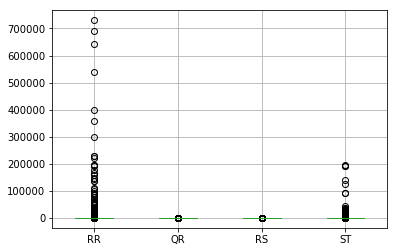

In [27]:
no_dups[['RR','QR', 'RS','ST']].boxplot()

### Hay RR que son muy altos, puede deberse a que el segmento de señal analizado no detecta latidos y salta, por lo tanto se deben ignorar para el análisis, suponiendo que el mínimo HR es 40 bpm, los pícos R deberían estar como máximo separados por 1.5 segundos  60s / (40 b/min), por lo tanto quitamos para el análisis de cluster los elementos que tengan más de 1.5* fs(125)  de distancia entre picos (189)

In [28]:
no_dups=no_dups[no_dups.RR<189]

In [29]:
len(no_dups)

14306737

In [30]:
no_dups.groupby('died').count()['RR']

died
False    10305803
True      4000934
Name: RR, dtype: int64

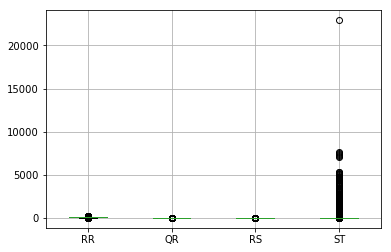

In [31]:
no_dups[['RR','QR', 'RS','ST']].boxplot()

### Persisten problemas con la calidad de los ST, esto se puede deber a que el pico T no esta siendo debidamente identificado dentro del complejo y esta siendo detectado en picos de más adelante. Se descartan estos latidos para continuar el análisis.

In [32]:
no_dups.ST.describe()

count    1.430337e+07
mean     1.669774e+01
std      1.408851e+01
min      4.000000e+00
25%      1.200000e+01
50%      1.300000e+01
75%      2.100000e+01
max      2.291700e+04
Name: ST, dtype: float64

In [33]:
per_75_IQR=np.percentile(no_dups.ST.dropna(),75)+1.5*stats.iqr(no_dups.ST.dropna())
per_75_IQR

34.5

In [34]:
np.sum(no_dups.ST>=per_75_IQR)

757625

In [35]:
no_dups=no_dups[no_dups.ST<per_75_IQR]

In [36]:
len(no_dups)

13545747

In [37]:
no_dups.groupby('died').count()['ST']

died
False    9670981
True     3874766
Name: ST, dtype: int64

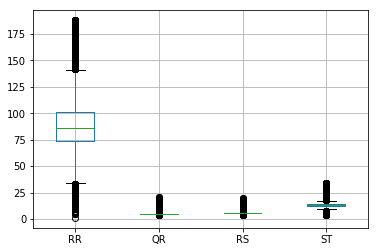

In [38]:
no_dups[['RR','QR', 'RS','ST']].boxplot()

## Comparamos individualmente las variables independientes frente a la variable objetivo

In [39]:
from scipy.stats import ttest_ind

## RR

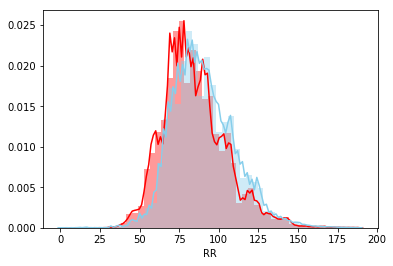

In [40]:
sns.distplot(no_dups[no_dups['died']==True].RR, color='red', label='died')
sns.distplot(no_dups[no_dups['died']==False].RR, color='skyblue', label='not died')

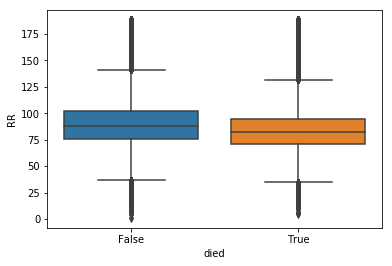

In [41]:
sns.boxplot(data=no_dups,y='RR', x='died')

In [42]:
#Null is equal averages, discarded
ttest_ind(no_dups[no_dups['died']==True].RR,no_dups[no_dups['died']==False].RR, equal_var=False)

Ttest_indResult(statistic=-492.4343534687144, pvalue=0.0)

## QR

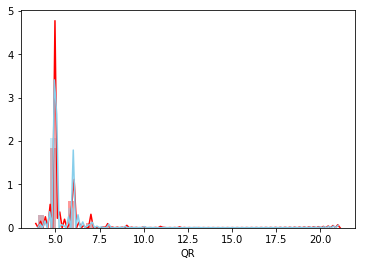

In [43]:
sns.distplot(no_dups[no_dups['died']==True].QR, color='red', label='died')
sns.distplot(no_dups[no_dups['died']==False].QR, color='skyblue', label='not died')

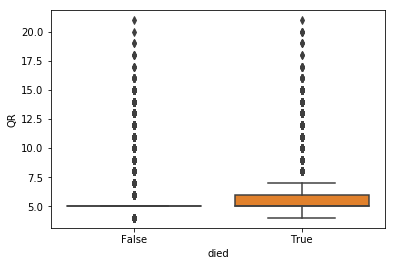

In [44]:
sns.boxplot(data=no_dups,y='QR', x='died')

In [45]:
#Null is equal averages, discarded
ttest_ind(no_dups[no_dups['died']==True].QR,no_dups[no_dups['died']==False].QR, equal_var=False)

Ttest_indResult(statistic=242.39117956818782, pvalue=0.0)

## RS

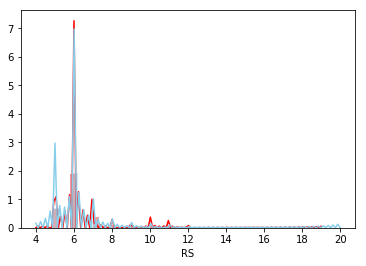

In [46]:
sns.distplot(no_dups[no_dups['died']==True].RS, color='red', label='died')
sns.distplot(no_dups[no_dups['died']==False].RS, color='skyblue', label='not died')

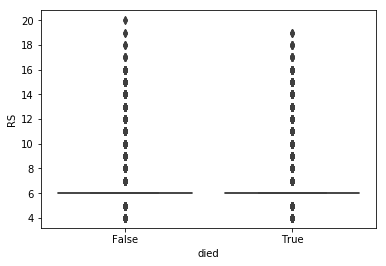

In [47]:
sns.boxplot(data=no_dups,y='RS', x='died')

In [48]:
#Null is equal averages, discarded
ttest_ind(no_dups[no_dups['died']==True].RS,no_dups[no_dups['died']==False].RS, equal_var=False)

Ttest_indResult(statistic=325.6491775371065, pvalue=0.0)

## ST

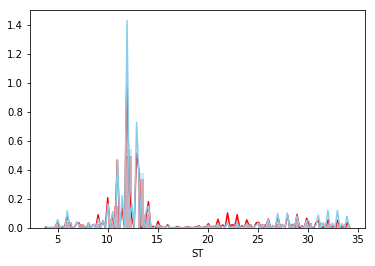

In [49]:
sns.distplot(no_dups[no_dups['died']==True].ST, color='red', label='died')
sns.distplot(no_dups[no_dups['died']==False].ST, color='skyblue', label='not died')

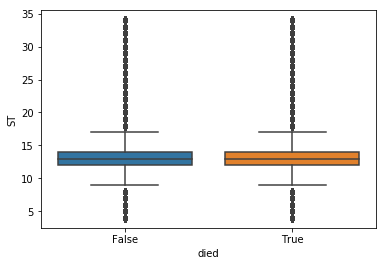

In [50]:
sns.boxplot(data=no_dups,y='ST', x='died')

In [51]:
#Null is equal averages, discarded
ttest_ind(no_dups[no_dups['died']==True].ST,no_dups[no_dups['died']==False].ST, equal_var=False)

Ttest_indResult(statistic=-51.25991705246479, pvalue=0.0)

## T

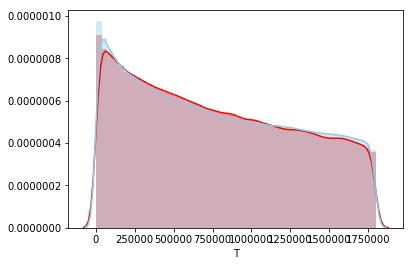

In [52]:
sns.distplot(no_dups[no_dups['died']==True]['T'], color='red', label='died')
sns.distplot(no_dups[no_dups['died']==False]['T'], color='skyblue', label='not died')

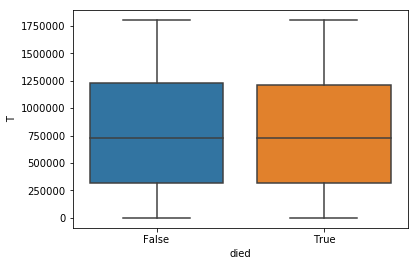

In [53]:
sns.boxplot(data=no_dups,y='T', x='died')

In [54]:
#Null is equal averages, discarded
ttest_ind(no_dups[no_dups['died']==True]['T'],no_dups[no_dups['died']==False]['T'], equal_var=False)

Ttest_indResult(statistic=-13.287478066778165, pvalue=2.7394555060403106e-40)

In [55]:
no_dups.shape

(13545747, 15)

### Quitamos T ya que no parece tener diferencia para el fenómeno

In [56]:
no_dups=no_dups.drop_duplicates(subset=['RR','QR', 'RS','ST'])

In [57]:
no_dups.isnull().sum(axis = 0)

R           0
R_val       0
RR          0
RR_val      0
Q           0
Q_val       0
S           0
S_val       0
T           0
T_val       0
died        0
filename    0
QR          0
RS          0
ST          0
dtype: int64

In [58]:
no_dups[['RR','QR', 'RS','ST']].describe()

,RR,QR,RS,ST
count,114129.000000,114129.000000,114129.000000,114129.00000
mean,91.547223,6.695240,8.143934,17.93651
std,34.231179,2.060966,2.510968,8.36643
min,1.000000,4.000000,4.000000,4.00000
25%,66.000000,5.000000,6.000000,11.00000
50%,89.000000,6.000000,8.000000,17.00000
75%,115.000000,8.000000,10.000000,25.00000
max,188.000000,21.000000,20.000000,34.00000


In [59]:
no_dups.shape

(114129, 15)

## Aplicamos estadarización de features

In [60]:
scaler= preprocessing.RobustScaler().fit(no_dups[['RR','QR', 'RS','ST']])

In [61]:
X=scaler.transform(no_dups[['RR','QR', 'RS','ST']])

In [62]:
X

array([[ 0.3877551 ,  0.33333333,  0.75      , -0.57142857],
       [ 0.36734694,  0.33333333,  0.75      , -0.5       ],
       [ 0.36734694,  0.33333333,  0.75      , -0.57142857],
       ...,
       [-0.57142857,  0.66666667,  0.25      , -0.28571429],
       [-1.20408163, -0.33333333, -0.25      ,  0.64285714],
       [-0.57142857, -0.33333333,  0.75      ,  0.28571429]])

In [63]:
pd.DataFrame(X, columns=['RR','QR', 'RS','ST']).describe()

,RR,QR,RS,ST
count,114129.000000,114129.000000,114129.000000,114129.000000
mean,0.051984,0.231747,0.035983,0.066894
std,0.698595,0.686989,0.627742,0.597602
min,-1.795918,-0.666667,-1.000000,-0.928571
25%,-0.469388,-0.333333,-0.500000,-0.428571
50%,0.000000,0.000000,0.000000,0.000000
75%,0.530612,0.666667,0.500000,0.571429
max,2.020408,5.000000,3.000000,1.214286


In [64]:
from sklearn.decomposition import PCA

In [65]:
pca = PCA()
x_new = pca.fit_transform(X)

In [66]:
help(pca)

Help on PCA in module sklearn.decomposition.pca object:

class PCA(sklearn.decomposition.base._BasePCA)
 |  PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)
 |  
 |  Principal component analysis (PCA)
 |  
 |  Linear dimensionality reduction using Singular Value Decomposition of the
 |  data to project it to a lower dimensional space.
 |  
 |  It uses the LAPACK implementation of the full SVD or a randomized truncated
 |  SVD by the method of Halko et al. 2009, depending on the shape of the input
 |  data and the number of components to extract.
 |  
 |  It can also use the scipy.sparse.linalg ARPACK implementation of the
 |  truncated SVD.
 |  
 |  Notice that this class does not support sparse input. See
 |  :class:`TruncatedSVD` for an alternative with sparse data.
 |  
 |  Read more in the :ref:`User Guide <PCA>`.
 |  
 |  Parameters
 |  ----------
 |  n_components : int, float, None or string
 |      Number of co

In [67]:
print( pca.components_ )

[[-0.56617236  0.7575647   0.31704804 -0.0708881 ]
 [ 0.80064933  0.43975697  0.32394304 -0.2462425 ]
 [ 0.01867273 -0.2425563   0.75034586  0.61465345]
 [ 0.19509187  0.41698439 -0.48116789  0.74601652]]


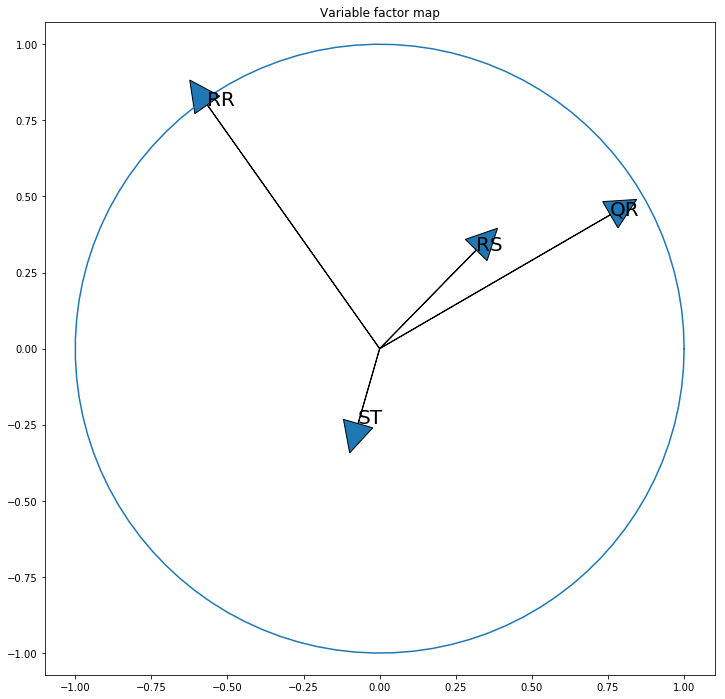

In [68]:
(fig, ax) = plt.subplots(figsize=(12, 12))
cols=['RR','QR', 'RS','ST']
for i in range(0, len(pca.components_)):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.1,
             head_length=0.1)
    plt.text(pca.components_[0, i] ,
         pca.components_[1, i] ,
         cols[i], fontsize=20)

an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Variable factor map')
plt.show()

In [69]:
print(pca.explained_variance_ratio_)

[0.30560304 0.28072357 0.2242356  0.18943779]


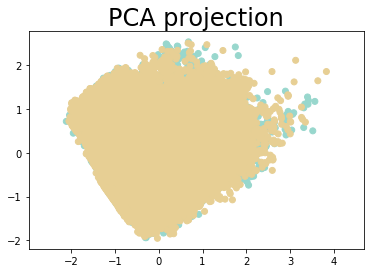

In [70]:
plt.scatter(x_new[:, 0], x_new[:, 1], c=[sns.color_palette("BrBG", 2)[x] for x in no_dups['died']])
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA projection', fontsize=24);

In [71]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.externals.joblib import Parallel, delayed


### HDBSCAN

In [72]:
import hdbscan

In [73]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, gen_min_span_tree=True)
clusterer.fit(X)

C:\Users\AndresM\Anaconda3\envs\HR_Analysis\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\AndresM\Anaconda3\envs\HR_Analysis\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\AndresM\Anaconda3\envs\HR_Analysis\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\AndresM\Anaconda3\envs\HR_Analysis\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=100, min_samples=None, p=None,
    prediction_data=False)

In [74]:
matplotlib.rc('figure', figsize=[20,20])

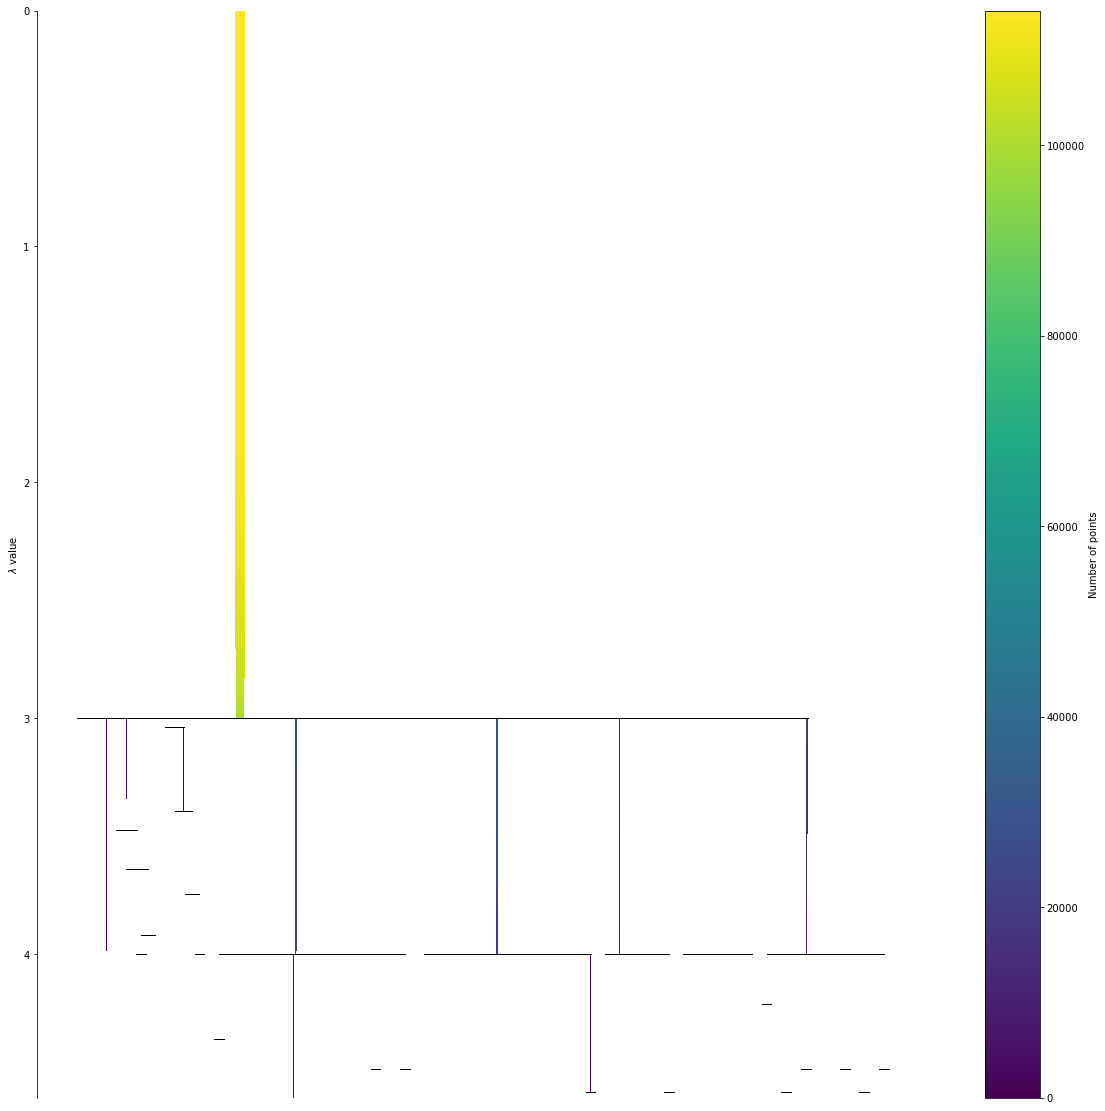

In [75]:
clusterer.condensed_tree_.plot()

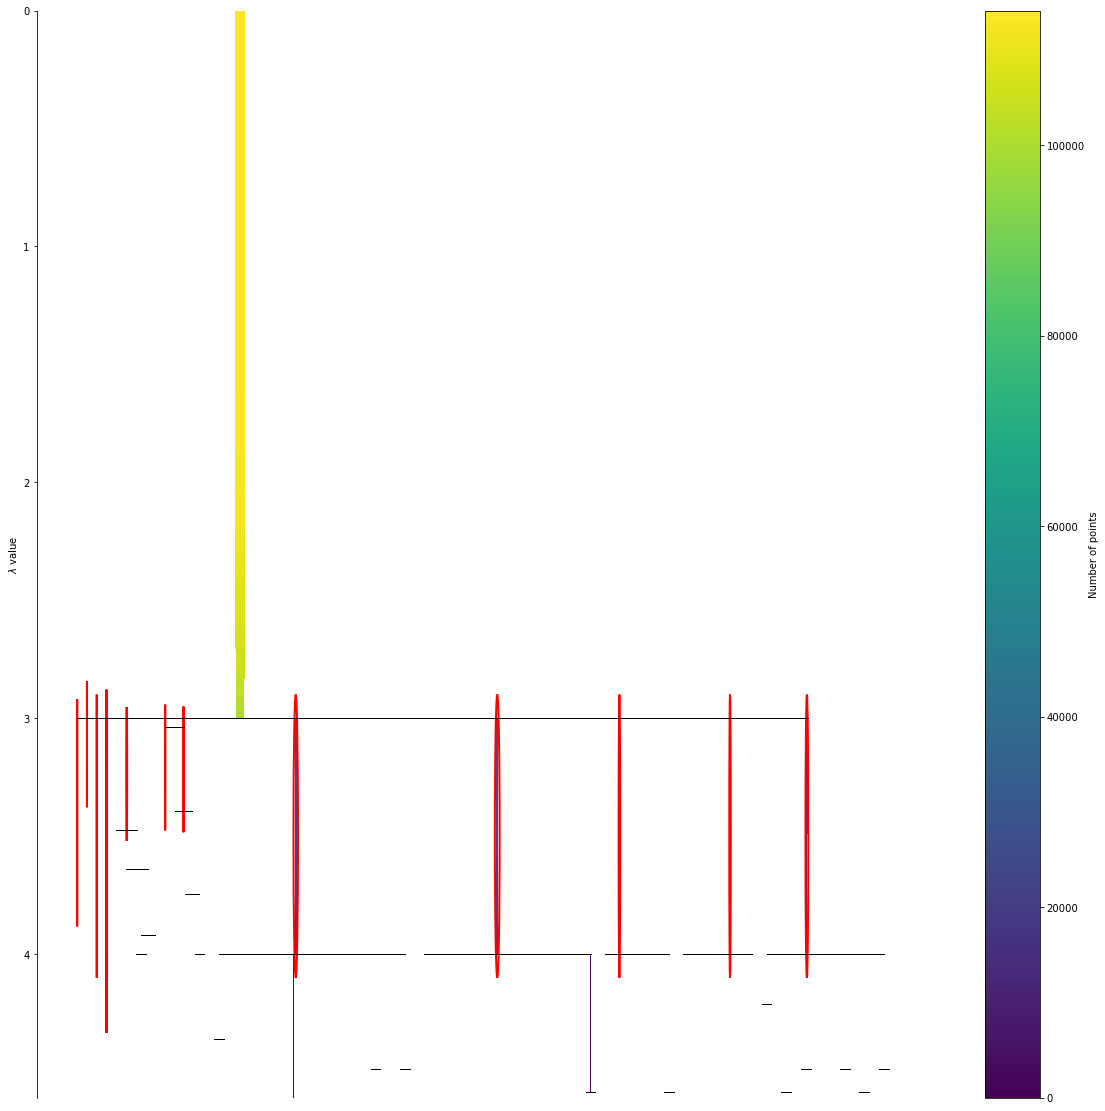

In [76]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [77]:
np.unique(clusterer.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64),
 array([14826,   493,   150,   983,  1665,  5212,  8643, 26116, 27963,
         8582, 16384,   182,  2930], dtype=int64))

In [78]:
clusterer.probabilities_

array([1.        , 1.        , 1.        , ..., 1.        , 0.89806271,
       1.        ])

In [79]:
no_dups['labels']=clusterer.labels_

In [80]:
no_dups['lab']=no_dups.labels.map(lambda x: chr(97+x) if x!=-1 else ' ')

In [81]:
no_dups

,R,R_val,RR,RR_val,Q,Q_val,S,S_val,T,T_val,died,filename,QR,RS,ST,labels,lab
complex_id,,,,,,,,,,,,,,,,,
2,196.0,0.273716,108.0,-0.025238,189.0,-0.112431,207.0,-0.267308,216.0,0.190225,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9,j
3,303.0,0.274182,107.0,0.000467,296.0,-0.091532,314.0,-0.269447,324.0,0.211441,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,10.0,9,j
5,518.0,0.295205,107.0,0.023682,511.0,-0.124722,529.0,-0.272963,538.0,0.202816,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9,j
6,624.0,0.378144,106.0,0.082939,618.0,-0.130054,632.0,-0.341294,643.0,0.148288,True,./signals/died/with_missing/p000491-2170-04-03...,6.0,8.0,11.0,7,h
7,733.0,0.265643,109.0,-0.112502,726.0,-0.103380,744.0,-0.259310,753.0,0.189169,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9,j
9,957.0,-0.396530,117.0,-0.666427,948.0,0.310781,967.0,0.197868,980.0,-0.130343,True,./signals/died/with_missing/p000491-2170-04-03...,9.0,10.0,13.0,4,e
10,1053.0,0.260240,96.0,0.656770,1047.0,-0.099309,1060.0,-0.235120,1071.0,0.100048,True,./signals/died/with_missing/p000491-2170-04-03...,6.0,7.0,11.0,7,h
11,1172.0,-0.391380,119.0,-0.651620,1163.0,0.289768,1182.0,0.212356,1195.0,-0.135169,True,./signals/died/with_missing/p000491-2170-04-03...,9.0,10.0,13.0,4,e
12,1279.0,-0.415892,107.0,-0.024511,1271.0,0.328723,1289.0,0.193760,1301.0,-0.124304,True,./signals/died/with_missing/p000491-2170-04-03...,8.0,10.0,12.0,8,i


In [82]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=(20,10)

In [83]:
X_sample=no_dups[['RR','QR', 'RS','ST','labels']].sample(5000)

In [84]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, perplexity=10,n_iter=5000).fit_transform(X_sample[['RR','QR', 'RS','ST']])


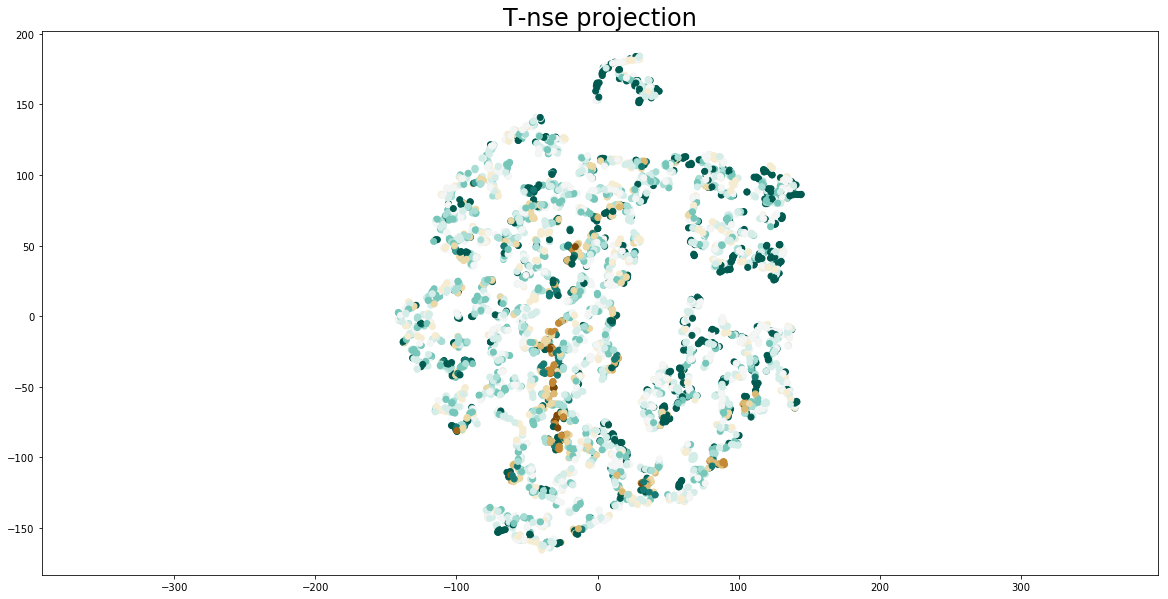

In [85]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=[sns.color_palette("BrBG",  X_sample['labels'].nunique())[x] for x in X_sample['labels']])
plt.gca().set_aspect('equal', 'datalim')
plt.title('T-nse projection', fontsize=24);

### convert files to Strings

In [86]:
result=result.merge(no_dups[['RR','QR','RS','ST','labels']], how='left')

In [87]:
result.head(20)

,R,R_val,RR,RR_val,Q,Q_val,S,S_val,T,T_val,died,filename,QR,RS,ST,labels
0,196.0,0.273716,108.0,-0.025238,189.0,-0.112431,207.0,-0.267308,216.0,0.190225,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9.0
1,303.0,0.274182,107.0,0.000467,296.0,-0.091532,314.0,-0.269447,324.0,0.211441,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,10.0,9.0
2,411.0,0.271524,108.0,-0.002659,404.0,-0.115924,422.0,-0.271142,431.0,0.185099,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9.0
3,518.0,0.295205,107.0,0.023682,511.0,-0.124722,529.0,-0.272963,538.0,0.202816,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9.0
4,624.0,0.378144,106.0,0.082939,618.0,-0.130054,632.0,-0.341294,643.0,0.148288,True,./signals/died/with_missing/p000491-2170-04-03...,6.0,8.0,11.0,7.0
5,733.0,0.265643,109.0,-0.112502,726.0,-0.103380,744.0,-0.259310,753.0,0.189169,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9.0
6,840.0,0.269897,107.0,0.004254,833.0,-0.110853,851.0,-0.273851,861.0,0.208425,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,10.0,9.0
7,957.0,-0.396530,117.0,-0.666427,948.0,0.310781,967.0,0.197868,980.0,-0.130343,True,./signals/died/with_missing/p000491-2170-04-03...,9.0,10.0,13.0,4.0
8,1053.0,0.260240,96.0,0.656770,1047.0,-0.099309,1060.0,-0.235120,1071.0,0.100048,True,./signals/died/with_missing/p000491-2170-04-03...,6.0,7.0,11.0,7.0
9,1172.0,-0.391380,119.0,-0.651620,1163.0,0.289768,1182.0,0.212356,1195.0,-0.135169,True,./signals/died/with_missing/p000491-2170-04-03...,9.0,10.0,13.0,4.0


In [88]:
sum(result.labels.isna())

800727

In [89]:
#Fill long R
group_RR=clusterer.labels_.max()+1
result['labels']=result[['RR','labels']].apply(lambda x: group_RR if x['RR']>=189 else x['labels'],axis=1 )

In [90]:
# Q, S ,T  is null
result['labels']=result[['Q','labels']].apply(lambda x: group_RR+1 if np.isnan(x['Q']) else x['labels'],axis=1 )
result['labels']=result[['S','labels']].apply(lambda x: group_RR+2 if np.isnan(x['S']) else x['labels'],axis=1 )
result['labels']=result[['T','labels']].apply(lambda x: group_RR+3 if np.isnan(x['T']) else x['labels'],axis=1 )

In [91]:
# ST
result['labels']=result[['ST','labels']].apply(lambda x: group_RR+4 if x['ST']>=per_75_IQR else x['labels'],axis=1 )


In [92]:
sum(result.labels.isna())

0

In [93]:
from IPython.display import Markdown as md

In [94]:
md(f'Group large RR is {chr(97+group_RR)} ({group_RR})')


Group large RR is m (12)

In [95]:
md(f'Group missing Q is {chr(97+group_RR+1)} ({group_RR+1})')

Group missing Q is n (13)

In [96]:
md(f'Group missing S is {chr(97+group_RR+2)} ({group_RR+2})')

Group missing S is o (14)

In [97]:
md(f'Group missing T is {chr(97+group_RR+3)} ({group_RR+3})')

Group missing T is p (15)

In [98]:
md(f'Group large ST is {chr(97+group_RR+4)} ({group_RR+4})')

Group large ST is q (16)

In [99]:
result['labels']=result['labels'].astype(int)

In [100]:
result['lab']=result.labels.map(lambda x: chr(97+x) if not(x==group_RR or x==-1) else ' ')

In [101]:
np.unique(result.labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 15, 16]),
 array([  37222,    4393,    1414,   10117,   26691,   61929, 1326014,
        9227067, 2328667,  147910,  386284,     379,   30645,   16742,
          19420,  764565], dtype=int64))

In [102]:
np.unique(result.lab, return_counts=True)

(array([' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
        'p', 'q'], dtype=object),
 array([  53964,    4393,    1414,   10117,   26691,   61929, 1326014,
        9227067, 2328667,  147910,  386284,     379,   30645,   19420,
         764565], dtype=int64))

In [103]:
result.head(20)

,R,R_val,RR,RR_val,Q,Q_val,S,S_val,T,T_val,died,filename,QR,RS,ST,labels,lab
0,196.0,0.273716,108.0,-0.025238,189.0,-0.112431,207.0,-0.267308,216.0,0.190225,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9,j
1,303.0,0.274182,107.0,0.000467,296.0,-0.091532,314.0,-0.269447,324.0,0.211441,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,10.0,9,j
2,411.0,0.271524,108.0,-0.002659,404.0,-0.115924,422.0,-0.271142,431.0,0.185099,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9,j
3,518.0,0.295205,107.0,0.023682,511.0,-0.124722,529.0,-0.272963,538.0,0.202816,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9,j
4,624.0,0.378144,106.0,0.082939,618.0,-0.130054,632.0,-0.341294,643.0,0.148288,True,./signals/died/with_missing/p000491-2170-04-03...,6.0,8.0,11.0,7,h
5,733.0,0.265643,109.0,-0.112502,726.0,-0.103380,744.0,-0.259310,753.0,0.189169,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,9.0,9,j
6,840.0,0.269897,107.0,0.004254,833.0,-0.110853,851.0,-0.273851,861.0,0.208425,True,./signals/died/with_missing/p000491-2170-04-03...,7.0,11.0,10.0,9,j
7,957.0,-0.396530,117.0,-0.666427,948.0,0.310781,967.0,0.197868,980.0,-0.130343,True,./signals/died/with_missing/p000491-2170-04-03...,9.0,10.0,13.0,4,e
8,1053.0,0.260240,96.0,0.656770,1047.0,-0.099309,1060.0,-0.235120,1071.0,0.100048,True,./signals/died/with_missing/p000491-2170-04-03...,6.0,7.0,11.0,7,h
9,1172.0,-0.391380,119.0,-0.651620,1163.0,0.289768,1182.0,0.212356,1195.0,-0.135169,True,./signals/died/with_missing/p000491-2170-04-03...,9.0,10.0,13.0,4,e


In [104]:
results_agg=result.groupby('filename').agg({'lab':lambda x: x.sum()}).reset_index()

In [105]:
results_agg=results_agg.merge(result[['filename','died']].drop_duplicates(), on='filename' )

In [106]:
results_agg.sample(20)

,filename,lab,died
402,./signals/not_died/with_missing/p006470-2148-0...,ggggggggghhghhhhhhghgggggghhghhhhhhhhggghggggg...,False
305,./signals/died/with_missing/p087481-2141-05-08...,ggggggggggghggggggggggggggggggggggghgggggggggg...,True
549,./signals/not_died/with_missing/p022491-2151-0...,gqggqgggghgqgggggghggghghgggggghqgggggghgggggq...,False
1210,./signals/not_died/with_missing/p085899-2158-0...,ggggggggggggghggggggggggggggggggggggggghgghggh...,False
55,./signals/died/with_missing/p014094-2196-11-08...,ggggggghggggggggggggghggggggggq fgqqhqggggggg...,True
1306,./signals/not_died/with_missing/p093898-2118-0...,gggghgggggggggghggggggfgggggggfhghghggghhggggg...,False
768,./signals/not_died/with_missing/p049245-2182-0...,gqhgggghggggghgggggggggggghggggggggghgghghgghg...,False
750,./signals/not_died/with_missing/p047715-2121-0...,gggghgqhhhqgqhhqghhqqgqhgqqqqqhgqqqqqqqqqqqhqq...,False
506,./signals/not_died/with_missing/p017366-2155-0...,hhhhhhhhhhhhhjhhhghhhhhhhhhhhhjjhhgjhhhhhhhhhh...,False
5,./signals/died/with_missing/p000773-2109-03-11...,fgfggggggggggfggggfggggggggggggfggfggggggggggg...,True


In [107]:
from nltk.tokenize import RegexpTokenizer

In [108]:
from nltk.util import ngrams

In [109]:
from collections import Counter

In [110]:
tokenizer = RegexpTokenizer('\S')

In [111]:
def tk(text):
    tokenizer = RegexpTokenizer('\S')
    return tokenizer.tokenize(text)

In [112]:
phrase_counter = Counter()
for l in results_agg.lab:
    tokens=tokenizer.tokenize(l)
    for phrase in ngrams(tokens, 2):
        phrase_counter[phrase] += 1
    for phrase in ngrams(tokens, 3):
        phrase_counter[phrase] += 1
    for phrase in ngrams(tokens, 4):
        phrase_counter[phrase] += 1
    for phrase in ngrams(tokens, 5):
        phrase_counter[phrase] += 1    

In [113]:
vocabulary=list(map( lambda x : ''.join(x[0]) ,phrase_counter.most_common(3000)))

In [114]:
len(vocabulary)

3000

In [115]:
results_agg.shape

(1374, 3)

In [116]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [186]:
from sklearn.model_selection import train_test_split

In [187]:
df_train, df_test = train_test_split( results_agg, test_size = .3, random_state = 2 )

In [188]:
tfidf = TfidfVectorizer(stop_words=[], tokenizer=tk, ngram_range=(1,6) )

In [189]:
tfidf.fit(df_train.lab)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 6), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=[], strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tk at 0x000002862019B488>, use_idf=True,
        vocabulary=None)

In [190]:
transformed_trained=tfidf.transform(df_train.lab)
transformed_test=tfidf.transform(df_test.lab)

In [191]:
dense_trained=transformed_trained.todense()
dense_test=transformed_test.todense()

In [192]:
dense_trained.shape

(961, 141692)

In [193]:
dense_test.shape

(413, 141692)

In [208]:
features=tfidf.get_feature_names()

In [201]:
df_tfidf_train=pd.DataFrame(dense_trained, index=df_train.index, columns= tfidf.get_feature_names())

In [202]:
df_tfidf_test=pd.DataFrame(dense_test, index=df_test.index, columns= tfidf.get_feature_names())

In [203]:
df_tfidf_train['label']=df_train['died']

In [204]:
df_tfidf_test['label']=df_test['died']

In [205]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score

In [209]:
len(features)

141692

In [210]:
df_tfidf_train[features]

,a,a a,a a a,a a a a,a a a a a,a a a a a a,a a a a a c,a a a a a h,a a a a a j,a a a a c,...,q q q q q e,q q q q q f,q q q q q g,q q q q q h,q q q q q i,q q q q q j,q q q q q k,q q q q q l,q q q q q p,q q q q q q
305,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1051,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.004662,0.011027,0.013225,0.000000,0.000000,0.0,0.000000,0.000000,0.427659
505,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
765,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
678,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000596,0.000357,0.000000,0.000000,0.0,0.000000,0.000210,0.003493
840,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1031,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.001270,0.001015,0.000000,0.000000,0.0,0.000000,0.000000,0.007545
93,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
969,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
866,0.000217,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000163,0.001026,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.004813


In [214]:
df_tfidf_train['label'].head()

305      True
1051    False
505     False
765     False
678     False
Name: label, dtype: bool

In [215]:
coefs = dict()
f1_score_dict = dict()

In [216]:
alphas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1]

In [218]:
def do_sample_iteration(alpha, data_train_ensa, features, i):
    print(f'Iteration {i}')
    print(datetime.datetime.now())
    all_indexes = set(data_train_ensa.index)
    sampled_dataset = resample(data_train_ensa, replace=True)
    not_sampled_dataset = data_train_ensa.loc[list(all_indexes - set(sampled_dataset.index))]
    model = SGDClassifier(loss='log', penalty='l1', alpha=alpha, fit_intercept=False, max_iter=600, learning_rate='adaptive',
                          eta0=0.001, class_weight='balanced',  verbose=0,tol=1e-3, n_iter_no_change=10, random_state=0)
    #model = LogisticRegression(penalty='l1', solver='liblinear', C=1 / alpha, max_iter=500, class_weight='balanced',
    #                           fit_intercept=False)
    model.fit(sampled_dataset[features], sampled_dataset['label'])
    coefs = model.coef_.flatten()
    bin_coefs = coefs != 0
    train_preds = model.predict(sampled_dataset[features])
    test_preds = model.predict(not_sampled_dataset[features])
    f_beta_train = fbeta_score(sampled_dataset['label'], train_preds, 1)
    f_beta_test = fbeta_score(not_sampled_dataset['label'], test_preds, 1)
    print(
        f'RESULTS: M:{i} alpha_:{alpha} f_beta_train:{f_beta_train} f_beta_test:{f_beta_test} '
        f'num_features {np.sum(bin_coefs)}')
    print(datetime.datetime.now())
    return {'i': i, 'coefs': coefs, 'bin_coefs': bin_coefs, 'f_beta_test': f_beta_test, 'f_beta_train': f_beta_train}


In [219]:
folds_results = pd.DataFrame(data=None,
                                 columns=['alpha', 'avg_f_beta', 'avg_f_beta_low', 'stability', 'stability_lower',
                                          'support','coefs_avg','coefs_std','coefs_mat','Z'])
for alpha in alphas:
    print(alpha)
    print(datetime.datetime.now())
    M = 100
    Z = np.zeros((M, len(features)), dtype=np.int8)
    coefs_mat = np.zeros((M, len(features)))
    f_betas = {}
    val = Parallel(n_jobs=5)(delayed(do_sample_iteration)(alpha, df_tfidf_train, features, i) for i in range(M))
    print(val)
    for x in val:
        i = x['i']
        f_beta_train = x['f_beta_train']
        f_beta_test = x['f_beta_test']
        bin_coefs = x['bin_coefs']
        Z[i] = bin_coefs
        coefs_mat[i] = x['coefs']
        f_betas[i] = np.asarray([f_beta_train, f_beta_test]).flatten()

    print(datetime.datetime.now())
    f_betas_df = pd.DataFrame.from_dict(f_betas, orient='index', columns=['train', 'test'])
    avg_fbeta = f_betas_df['test'].mean()
    se = scipy.stats.sem(f_betas_df['test'])
    h = se * scipy.stats.t.ppf((1 + 0.95) / 2., len(f_betas_df['test']) - 1)
    avg_fbeta_low = avg_fbeta - h
    confidence_results = confidenceIntervals(Z)
    support = Z.mean(axis=0)
    coefs_avg = coefs_mat.mean(axis=0)
    coefs_std = coefs_mat.std(axis=0)
    folds_results = folds_results.append(
        {'alpha': alpha, 'avg_f_beta': avg_fbeta, 'avg_f_beta_low': avg_fbeta_low,
         'stability': confidence_results['stability'],
         'stability_lower': confidence_results['lower'],
         'support': support,'coefs_avg':coefs_avg, 'coefs_std':coefs_std, 'coefs_mat': coefs_mat, 'Z':Z},
        ignore_index=True)

folds_results['l1_error'] = folds_results.apply(lambda row: (1 - row['stability_lower']) + (1 - row['avg_f_beta_low']), axis=1)
folds_results['num_features'] = folds_results.apply(lambda row: np.sum(row['support'] >= .9), axis=1)
mask = folds_results.loc[folds_results['l1_error'] == folds_results['l1_error'].min()]['support'].iloc[0] > .9
selected_features = np.array(features)[mask].tolist()

1e-06
2020-01-17 15:02:08.295143
[{'i': 0, 'coefs': array([ 1.57362903e-03,  1.97710840e-04, -6.27222428e-05, ...,
       -1.38630985e-05,  4.04239655e-03, -4.10684379e-02]), 'bin_coefs': array([ True,  True,  True, ...,  True,  True,  True]), 'f_beta_test': 0.308641975308642, 'f_beta_train': 0.33995584988962474}, {'i': 1, 'coefs': array([-1.74448863e-03, -2.74552741e-04, -4.76352073e-05, ...,
       -1.00913389e-04,  1.23071595e-03, -4.82197669e-03]), 'bin_coefs': array([ True,  True,  True, ...,  True,  True,  True]), 'f_beta_test': 0.3023255813953488, 'f_beta_train': 0.32286995515695066}, {'i': 2, 'coefs': array([ 6.43852822e-05,  1.69226914e-04,  0.00000000e+00, ...,
       -2.17606645e-05,  9.89314177e-05,  7.97720918e-03]), 'bin_coefs': array([ True,  True, False, ...,  True,  True,  True]), 'f_beta_test': 0.31000000000000005, 'f_beta_train': 0.3548983364140481}, {'i': 3, 'coefs': array([-1.63549348e-03, -3.91577957e-04, -2.46401857e-04, ...,
       -1.45759571e-04, -5.02286783e-

1e-05
2020-01-17 15:53:00.984472
[{'i': 0, 'coefs': array([0.0012691 , 0.        , 0.        , ..., 0.        , 0.0018069 ,
       0.01660395]), 'bin_coefs': array([ True, False, False, ..., False,  True,  True]), 'f_beta_test': 0.3195266272189349, 'f_beta_train': 0.3754646840148699}, {'i': 1, 'coefs': array([ 0.00166185,  0.00014158,  0.        , ...,  0.        ,
        0.00086549, -0.06997702]), 'bin_coefs': array([ True,  True, False, ..., False,  True,  True]), 'f_beta_test': 0.30434782608695654, 'f_beta_train': 0.34782608695652173}, {'i': 2, 'coefs': array([ 0.00806844,  0.001286  ,  0.        , ...,  0.        ,
        0.        , -0.07508248]), 'bin_coefs': array([ True,  True, False, ..., False, False,  True]), 'f_beta_test': 0.2839506172839506, 'f_beta_train': 0.350109409190372}, {'i': 3, 'coefs': array([ 0.01808331,  0.00281793,  0.        , ...,  0.        ,
        0.        , -0.03687995]), 'bin_coefs': array([ True,  True, False, ..., False, False,  True]), 'f_beta_tes

0.0001
2020-01-17 16:26:58.544450
[{'i': 0, 'coefs': array([0.00053905, 0.        , 0.        , ..., 0.        , 0.00115124,
       0.03178631]), 'bin_coefs': array([ True, False, False, ..., False,  True,  True]), 'f_beta_test': 0.31016042780748665, 'f_beta_train': 0.3584905660377359}, {'i': 1, 'coefs': array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        , -0.01830263]), 'bin_coefs': array([False, False, False, ..., False, False,  True]), 'f_beta_test': 0.33128834355828224, 'f_beta_train': 0.33472803347280333}, {'i': 2, 'coefs': array([ 0.00745815,  0.        ,  0.        , ...,  0.        ,
        0.        , -0.05636362]), 'bin_coefs': array([ True, False, False, ..., False, False,  True]), 'f_beta_test': 0.3459459459459459, 'f_beta_train': 0.3416856492027335}, {'i': 3, 'coefs': array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.00300237]), 'bin_coefs': array([False, False, False, ..., False, False,  True]), 'f_beta_test':

0.001
2020-01-17 17:24:53.908216
[{'i': 0, 'coefs': array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        , -0.00885081]), 'bin_coefs': array([False, False, False, ..., False, False,  True]), 'f_beta_test': 0.326241134751773, 'f_beta_train': 0.3127753303964758}, {'i': 1, 'coefs': array([ 0.        ,  0.        ,  0.        , ...,  0.        ,
        0.        , -0.00941907]), 'bin_coefs': array([False, False, False, ..., False, False,  True]), 'f_beta_test': 0.2808988764044944, 'f_beta_train': 0.38075313807531386}, {'i': 2, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.33532934131736525, 'f_beta_train': 0.36625514403292186}, {'i': 3, 'coefs': array([0.        , 0.        , 0.        , ..., 0.        , 0.        ,
       0.00026926]), 'bin_coefs': array([False, False, False, ..., False, False,  True]), 'f_beta_test': 0.3736263736263736, 'f_beta_train': 0.3705179282868526},

0.01
2020-01-17 17:58:33.059446
[{'i': 0, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0}, {'i': 1, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0}, {'i': 2, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.37647058823529406, 'f_beta_train': 0.4234234234234235}, {'i': 3, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0}, {'i': 4, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0}, {'i': 5, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ...,

0.1
2020-01-17 18:26:23.895939
[{'i': 0, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0}, {'i': 1, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0}, {'i': 2, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0}, {'i': 3, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0}, {'i': 4, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_test': 0.0, 'f_beta_train': 0.0}, {'i': 5, 'coefs': array([0., 0., 0., ..., 0., 0., 0.]), 'bin_coefs': array([False, False, False, ..., False, False, False]), 'f_beta_

C:\Users\AndresM\Anaconda3\envs\HR_Analysis\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\AndresM\Anaconda3\envs\HR_Analysis\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars


In [220]:
folds_results.to_pickle('fold_results_f1_500.pkl')

In [222]:
folds_results

,alpha,avg_f_beta,avg_f_beta_low,stability,stability_lower,support,coefs_avg,coefs_std,coefs_mat,Z,l1_error,num_features
0,0.000001,0.309140,0.301950,0.541209,0.532393,"[1.0, 0.96, 0.81, 0.67, 0.42, 0.21, 0.0, 0.01,...","[0.0019606924982956365, 0.0002629578172630801,...","[0.004206091776479795, 0.0007768085657435576, ...","[[0.0015736290272775559, 0.0001977108396774616...","[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.165657,5783
1,0.000010,0.313494,0.306067,0.603742,0.593889,"[0.97, 0.71, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.002567336909725422, 0.0003373226067048224, ...","[0.004027965003108493, 0.0006072600516844077, ...","[[0.0012690994951576379, 0.0, 0.0, 0.0, 0.0, 0...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.100044,884
2,0.000100,0.312016,0.305010,0.605050,0.595515,"[0.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0012197522072128256, 0.0, 0.0, 0.0, 0.0, 0....","[0.0026707613744834987, 0.0, 0.0, 0.0, 0.0, 0....","[[0.0005390476036923665, 0.0, 0.0, 0.0, 0.0, 0...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.099475,99
3,0.001000,0.313097,0.305819,0.602373,0.587557,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.106624,13
4,0.010000,0.063062,0.038573,0.363425,0.300969,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.660458,0
5,0.100000,0.000000,0.000000,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",NaN,0


In [223]:
len(selected_features)

89

In [224]:
selected_features

['d',
 'd d',
 'd d d',
 'f',
 'f f',
 'g',
 'g f',
 'g f g',
 'g g',
 'g g g',
 'g g g g',
 'g g g g g',
 'g g g g g g',
 'g g g q',
 'g g q',
 'g g q g',
 'g h',
 'g h g',
 'g h h',
 'g h h h',
 'g h h h h',
 'g h h h h h',
 'g q',
 'g q g',
 'g q g q',
 'h',
 'h g',
 'h g h',
 'h g h h',
 'h g h h h',
 'h g h h h h',
 'h h',
 'h h g h',
 'h h g h h',
 'h h g h h h',
 'h h h',
 'h h h g',
 'h h h g h',
 'h h h g h h',
 'h h h h',
 'h h h h g',
 'h h h h g h',
 'h h h h h',
 'h h h h h g',
 'h h h h h h',
 'h h h h h j',
 'h h h h j',
 'h h h h j h',
 'h h h j',
 'h h h j h',
 'h h h j h h',
 'h h j',
 'h h j h',
 'h h j h h',
 'h h j h h h',
 'h j',
 'h j h',
 'h j h h',
 'h j h h h',
 'i',
 'i i i',
 'i j j',
 'j',
 'j h',
 'j h h',
 'j h h h',
 'j h h h h',
 'j h j',
 'j i',
 'j i j j j',
 'j j',
 'j j h',
 'j j i',
 'j j j',
 'j j j j',
 'j j j j j',
 'j j j j j j',
 'l l l l l',
 'q',
 'q g',
 'q g g',
 'q g g g',
 'q g g g g',
 'q g q',
 'q q',
 'q q q',
 'q q q q',
 'q q q q q'

In [225]:
folds_results

,alpha,avg_f_beta,avg_f_beta_low,stability,stability_lower,support,coefs_avg,coefs_std,coefs_mat,Z,l1_error,num_features
0,0.000001,0.309140,0.301950,0.541209,0.532393,"[1.0, 0.96, 0.81, 0.67, 0.42, 0.21, 0.0, 0.01,...","[0.0019606924982956365, 0.0002629578172630801,...","[0.004206091776479795, 0.0007768085657435576, ...","[[0.0015736290272775559, 0.0001977108396774616...","[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.165657,5783
1,0.000010,0.313494,0.306067,0.603742,0.593889,"[0.97, 0.71, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.002567336909725422, 0.0003373226067048224, ...","[0.004027965003108493, 0.0006072600516844077, ...","[[0.0012690994951576379, 0.0, 0.0, 0.0, 0.0, 0...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.100044,884
2,0.000100,0.312016,0.305010,0.605050,0.595515,"[0.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0012197522072128256, 0.0, 0.0, 0.0, 0.0, 0....","[0.0026707613744834987, 0.0, 0.0, 0.0, 0.0, 0....","[[0.0005390476036923665, 0.0, 0.0, 0.0, 0.0, 0...","[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.099475,99
3,0.001000,0.313097,0.305819,0.602373,0.587557,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.106624,13
4,0.010000,0.063062,0.038573,0.363425,0.300969,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1.660458,0
5,0.100000,0.000000,0.000000,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",NaN,0


In [226]:
coef_avg_min=folds_results.loc[folds_results['l1_error'] == folds_results['l1_error'].min()]['coefs_avg'].iloc[0]
coef_std_min=folds_results.loc[folds_results['l1_error'] == folds_results['l1_error'].min()]['coefs_std'].iloc[0]
coef_support=folds_results.loc[folds_results['l1_error'] == folds_results['l1_error'].min()]['support'].iloc[0]
coefs_df=pd.DataFrame({'coef_val':coef_avg_min, 'coef_std_min':coef_std_min, 'coef_support':coef_support}, index=features)
coefs_df.nlargest(20,columns='coef_val')


,coef_val,coef_std_min,coef_support
h,0.154876,0.063303,1.00
h h,0.140463,0.048232,1.00
h h h,0.137046,0.044646,1.00
h h h h,0.121435,0.041577,1.00
h h h h h,0.109790,0.039697,1.00
h h h h h h,0.095447,0.036702,1.00
j,0.069097,0.037011,0.98
j j,0.060959,0.037939,0.99
j j j,0.051177,0.033290,1.00
j j j j,0.038097,0.026966,0.98


In [227]:
coefs_df.nsmallest(20,columns='coef_val')

,coef_val,coef_std_min,coef_support
g g,-0.080322,0.029262,1.00
g g g,-0.077914,0.035442,1.00
g g g g,-0.076779,0.041519,0.99
g,-0.075879,0.041841,1.00
g g g g g,-0.070721,0.044947,0.99
g g g g g g,-0.064632,0.046288,0.99
q q q q q q,-0.036947,0.039996,0.97
q,-0.030370,0.047990,0.99
q q q q q,-0.028073,0.039631,0.95
q q,-0.025197,0.038003,0.95


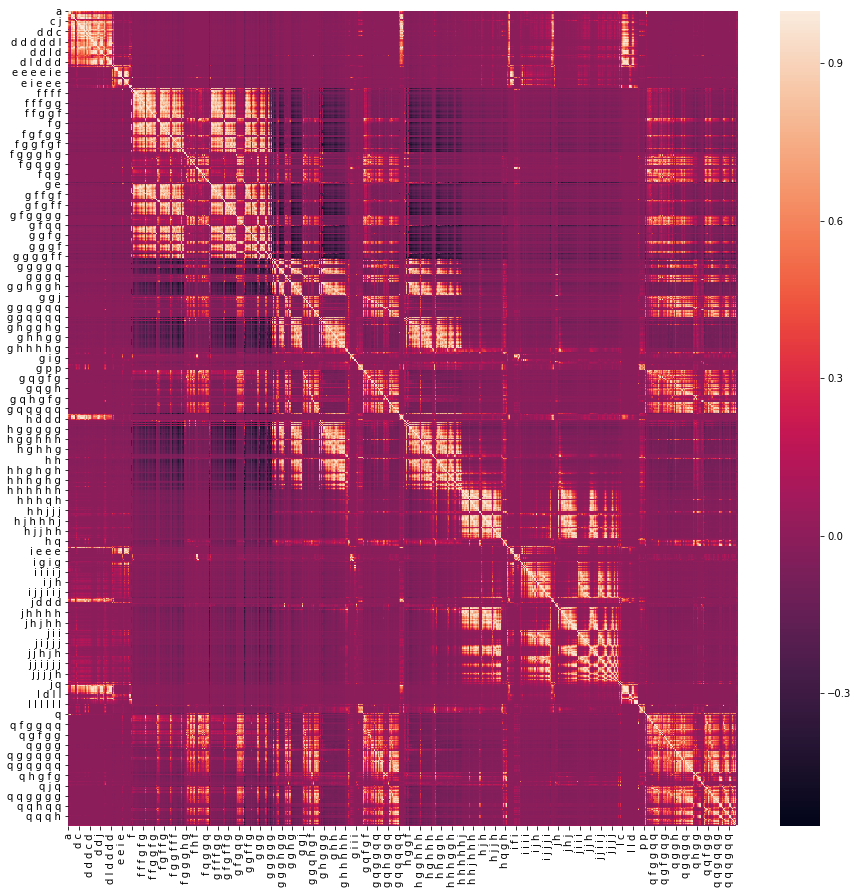

In [140]:
plt.rcParams['figure.figsize']=(15,15)
sns.heatmap(df_tfidf[selected_features+['label']].corr())

In [ ]:
pd.DataFrame()

In [141]:
df_tfidf['label'].describe()

count      1374
unique        2
top       False
freq       1027
Name: label, dtype: object

In [142]:
no_dups_2=result.drop_duplicates()

In [143]:
plt.rcParams['figure.figsize']=(12,6)

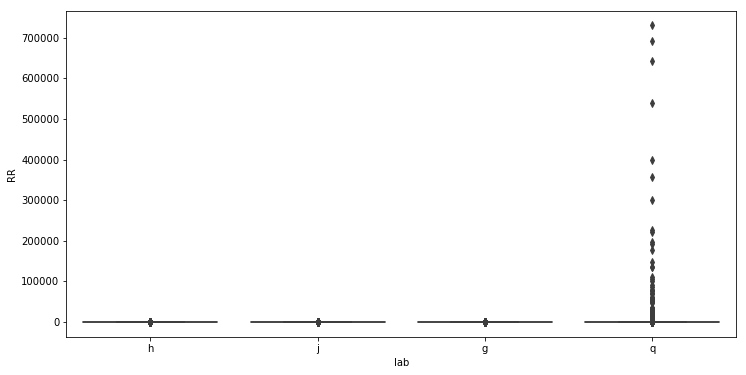

In [228]:
sns.boxplot(x="lab",y="RR", data=no_dups_2[no_dups_2.lab.isin(['h','j','g','q'])],order=['h','j','g','q'])

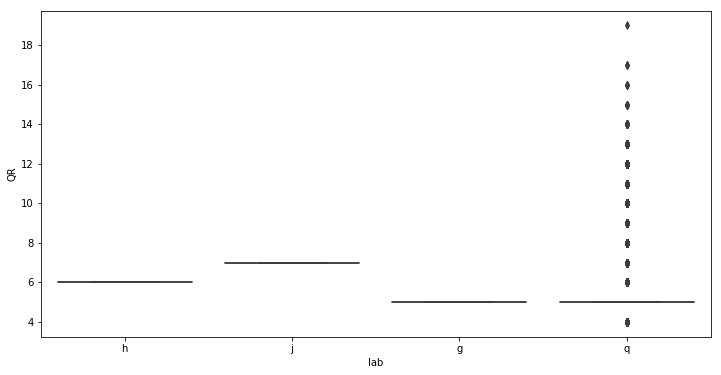

In [229]:
sns.boxplot(x="lab",y="QR", data=no_dups_2[no_dups_2.lab.isin(['h','j','g','q'])],order=['h','j','g','q'])

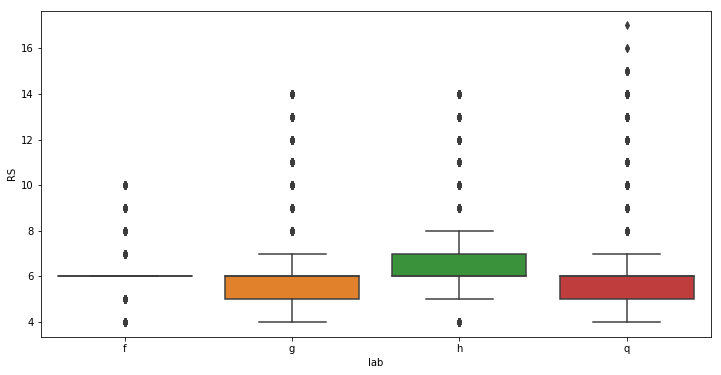

In [177]:
sns.boxplot(x="lab",y="RS", data=no_dups_2[no_dups_2.lab.isin(['f','g','h','q'])],order=['f','g','h','q'])

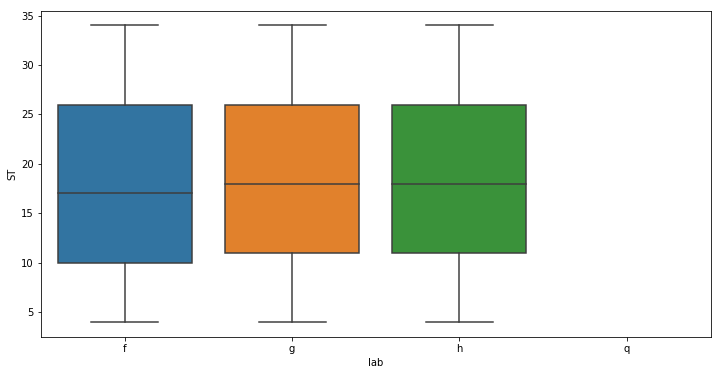

In [171]:
sns.boxplot(x="lab",y="ST", data=no_dups[no_dups.lab.isin(['f','g','h','q'])],order=['f','g','h','q'])